### Setup

In [1]:
from pylab import *
%matplotlib inline
import seaborn
import pandas as pd
import GetPbP
import PbPMethods2 as pm2
from scipy.stats import beta, gamma

### Introduction
<p>Teams run hot and cold in terms of goal-scoring seemingly all the time. Sometimes, this is just randomness. Other times, it's not. Numerically, how long do they have to be in a slump before their shooting percentage is evidence of poor shot quality and/or quantity? 
<p>In other words, without looking at inputs for goal scoring--like shot quantity, shot location, and [passing before shots](http://nhlnumbers.com/2016/8/10/passing-project-dangerous-primary-shot-contributions), to name a few--how bad does a team's goal-scoring rate need to be before it, by itself, is pretty good evidence <i>something</i> is actually wrong?
<p>As with [Columbus' 5v5 success](https://github.com/muneebalam/Hockey/blob/master/NHL/Posts/CBJ%20Bayesian%20evaluation.ipynb) and [Crosby's goal-scoring](https://github.com/muneebalam/Hockey/blob/master/NHL/Posts/Crosby%20Bayesian%20scoring.ipynb), I'll look at this question from a Bayesian perspective. I'll handle both shooting percentage and goal quantity, at 5-on-5 only for now.

In [2]:
### Generate data
GENERATE_DATA = False
filename = './team by team gf sf toi.csv'
if GENERATE_DATA:
    w = open(filename, 'w')
    w.write('Team,Season,HR,G,SOG,TOI')
    for season in range(2007, 2017):
        for team in pm2.get_teams(season):
            g = {'Home': 0, 'Road': 0}
            sog = {'Home': 0, 'Road': 0}
            toi = {'Home': 0, 'Road': 0}
            for line in pm2.read_team_corsi(team, season):
                if line[1][0] == '@':
                    homeroad = 'Home'
                else:
                    homeroad = 'Road'
                if pm2.get_acting_team(line) == team:
                    if pm2.get_event_type(line) == 'GOAL':
                        g[homeroad] += 1
                        sog[homeroad] += 1
                    elif pm2.get_event_type(line) == 'SHOT':
                        sog[homeroad] += 1
            for line in pm2.read_team_toi(team, season):
                if line[1][0] == '@':
                    homeroad = 'Home'
                else:
                    homeroad = 'Road'
                toi[homeroad] += 1
            
            for hr in ['Home', 'Road']:
                w.write('\n{0:s},{1:d},{2:s},{3:d},{4:d},{5:d}'.format(team, season, hr, g[hr], sog[hr], toi[hr]))
            w.write('\n{0:s},{1:d},{2:s},{3:d},{4:d},{5:d}'.format(team, season, 'Total', 
                                                                   g['Home'] + g['Road'], 
                                                                   sog['Home'] + sog['Road'],
                                                                   toi['Home'] + toi['Road']))
        print('Done with', season)
    w.close()
    
### Read in data
df = pd.read_csv('./team by team gf sf toi.csv') #File in GitHub folder
df['TOI2'] = df.TOI / 3600
df['G60'] = df.G / df.TOI2
df['SOG60'] = df.SOG / df.TOI2
df['ShP'] = df.G / df.SOG
df.head()

,Team,Season,HR,G,SOG,TOI,TOI2,G60,SOG60,ShP
0,CBJ,2007,Home,48,822,101634,28.231667,1.700218,29.116241,0.058394
1,CBJ,2007,Road,63,871,108879,30.244167,2.083046,28.798942,0.072331
2,CBJ,2007,Total,111,1693,210513,58.475833,1.898220,28.952131,0.065564
3,DAL,2007,Home,78,931,129511,35.975278,2.168156,25.878883,0.083781
4,DAL,2007,Road,90,1013,136887,38.024167,2.366916,26.640952,0.088845


### Priors
<p>For goals per 60 and shooting percentage prior, let's use HR = 'Total'. I'll assume scorer bias is not a big deal here; if it is, it would be worthwhile to use HR = 'Road' when dealing with SOG counts.

In [3]:
g60df = df[(df.Season < 2016) & (df.HR == 'Total')]
shpdf = df[(df.Season < 2016) & (df.HR == 'Total')]

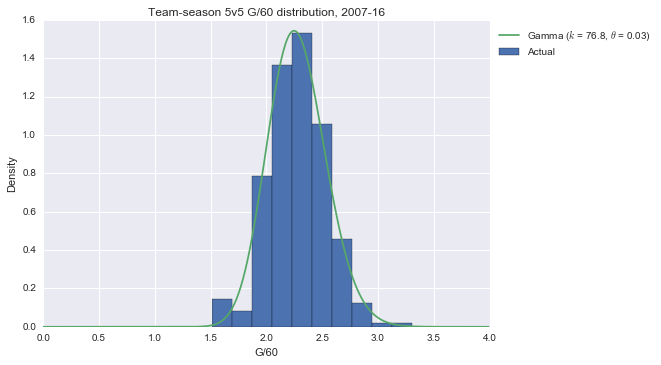

In [4]:
### Plot G60
xs_g60 = arange(0, 4, 0.01)

hist(g60df.G60, normed=True, label='Actual')
xlabel('G/60')
ylabel('Density')
title('Team-season 5v5 G/60 distribution, 2007-16')

k_g60, loc_g60, theta_g60 = gamma.fit(g60df.G60, floc=0)
plot(xs_g60, gamma.pdf(xs_g60, k_g60, loc_g60, theta_g60), 
     label=r"Gamma ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(k_g60, theta_g60))

legend(loc=2, bbox_to_anchor=(1, 1))

This looks like a pretty decent fit. We're centered at $\frac{k}{1/\theta} = \frac{76.8}{1/0.03} = 2.3$. The $k$ and $\theta$ values mean, in a sense, we give each team a "head start" of ~77 GF and ~33.3 "60s" played. Then, we tack on their season-to-date stats to get the probability distribution for their "true" goal-scoring frequency.

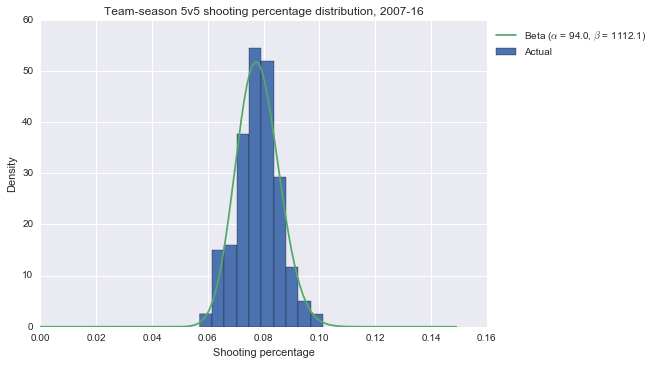

In [5]:
### Plot Sh%
xs_shp = arange(0, 0.15, 0.001)

hist(shpdf.ShP, normed=True, label='Actual')
xlabel('Shooting percentage')
ylabel('Density')
title('Team-season 5v5 shooting percentage distribution, 2007-16')

a_shp, b_shp, loc_shp, scale_shp = beta.fit(shpdf.ShP, floc=0, fscale=1)
plot(xs_shp, beta.pdf(xs_shp, a_shp, b_shp, loc_shp, scale_shp), 
     label=r"Beta ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_shp, b_shp))

legend(loc=2, bbox_to_anchor=(1, 1))

This also looks like a pretty decent fit, although the left half of the distribution might have a little plateau (the second and third bars from the left) that's not exactly captured. Nonetheless, I'll assume it's good enough for now. This distribution is centered at $\frac{\alpha}{\alpha + \beta} = \frac{94}{94 + 1112} = 0.078$. ($\alpha$ = "successes" and $\beta$ = "failures".)
<p>I'll assume away effects from shooting percentage decreasing slightly over time (see chart below and note the red lines--the medians), rink bias, and score effects. (On the latter point, if you're in an offensive slump, you're likely to trail more. [Trailing teams have slightly lower shooting percentage but score a tad more goals](http://nhlnumbers.com/2014/10/24/score-adjusted-pdo).)

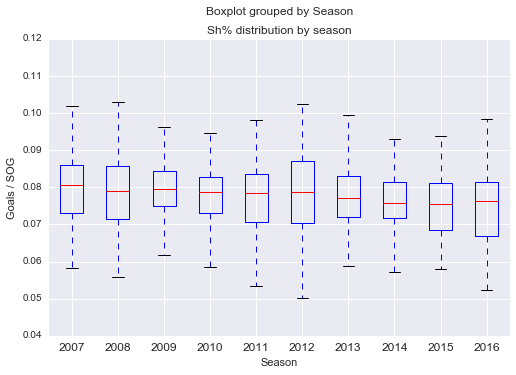

In [6]:
# Team shooting pct by season
df.boxplot(column='ShP', by='Season')
title('Sh% distribution by season')
xlabel('Season')
ylabel('Goals / SOG')

### Defining a slump
<p>Next, we need to define what we mean by a "slump." If a team averages 3 goals per 60 and drops to 2.9, that's an imperceptible difference in a short period of time. 
<p>I think it might be best to set several thresholds and repeat the calculations for each one--maybe 1, 2, and 3 standard deviations below the mean for both goals per 60 and shooting percentage.
<p>We can do the same thing for slumps, setting several TOI thresholds. I feel like around 5-10 games is when fans start to think their team might be slumping offensively, so let's start at five 60s. (A "60" is 60 minutes of 5-on-5. There are around 45 minutes of 5-on-5 per game, on average.) My gut feeling is that teams can slump due to randomness for as much as half a season, so call that 30 60s. So I'll go from five to 30 in increments of, let's say five.

In [7]:
### Find threshold values
g60_sd = df[(df.Season < 2016) & (df.HR == 'Total')]['G60'].std()
g60_mean = df[(df.Season < 2016) & (df.HR == 'Total')]['G60'].mean()
shp_sd = df[(df.Season < 2016) & (df.HR == 'Total')]['ShP'].std()
shp_mean = df[(df.Season < 2016) & (df.HR == 'Total')]['ShP'].mean()

g60_thresholds = [g60_mean - i * g60_sd for i in range(1, 4)]
shp_thresholds = [shp_mean - i * shp_sd for i in range(1, 4)]
toi_thresholds = [i for i in range(5, 31, 5)]

print('G/60 thresholds:', g60_thresholds)
print('Sh% thresholds:', shp_thresholds)
print('TOI thresholds:', toi_thresholds)

G/60 thresholds: [2.0182473104511534, 1.7594457063190641, 1.5006441021869745]
Sh% thresholds: [0.070268930100847005, 0.062578760678305839, 0.05488859125576466]
TOI thresholds: [5, 10, 15, 20, 25, 30]


Finally, we also need to decide what constitutes verification of the existence of the slump in the posterior distribution. In other words, even one game of a low G/60 would cause our posterior to shift to the left, so we need to decide how much of a shift is "significant."
<p>Alternatively, we can just find the probability that our "true talent" scoring ability is below average. Visually, if you draw a vertical line at the average, this probability is the area to the left. (The area under the entire curve equals one.) This way, we don't need to worry about cutoffs potentially making things strange.

### Posteriors (G/60)
<p>Now, it's time to calculate posteriors. What we'll do is apply each goals-per-60 and each shooting percentage threshold to each TOI threshold, given the prior for that stat:
<ul>
<li>Scoring 2.01 G/60 for 5 sixties
<li>Scoring 1.76 G/60 for 5 sixties
<li>Scoring 1.50 G/60 for 5 sixties
<li>Scoring 2.02 G/60 for 10 sixties
<li>Scoring 1.76 G/60 for 10 sixties
<li>Scoring 1.50 G/60 for 10 sixties
<li>(etc)
</ul>
<p>That's eighteen posteriors for each of the two stats. I'll create one plot for each stat for each TOI threshold to summarize the results visually.

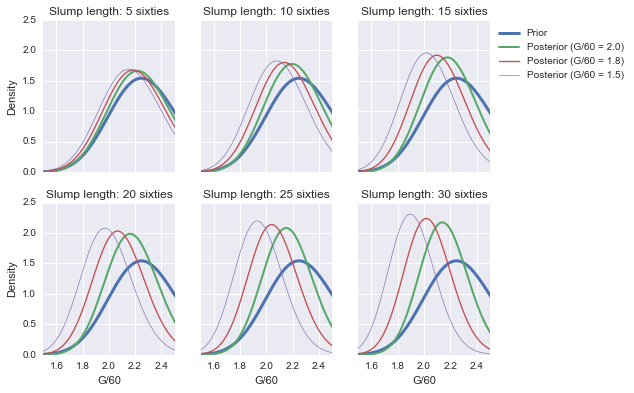

In [8]:
### Goals/60
fig, axes = subplots(2, 3, figsize=[8, 6], sharex=True, sharey=True)

probs = arange(0.01, 1, 0.01)
below_avg_probs = {'G/60 during slump': [], 'Slump length': [], 'Probability (Z < 0)': [], 'Probability (Z < -1)': []}

for i in range(len(toi_thresholds)):
    row = i//3
    col = i % 3
    
    ax = axes[row, col]
    ax.plot(xs_g60, gamma.pdf(xs_g60, k_g60, loc_g60, theta_g60), lw=3, label="Prior")
    
    for j in range(len(g60_thresholds)):
        g60_thresh = g60_thresholds[j]
        updated_k = k_g60 + g60_thresh * toi_thresholds[i]
        updated_theta = theta_g60/(theta_g60 * toi_thresholds[i] + 1)
        posterior = gamma.pdf(xs_g60, updated_k, loc_g60, updated_theta)
        ax.plot(xs_g60, posterior, lw = 2 - j*(2/len(g60_thresholds)), 
                label="Posterior (G/60 = {0:.1f})".format(g60_thresh))

        ax.set_xlim(1.5, 2.5)
        
        if row == 1:
            ax.set_xlabel('G/60')
        if col == 0:
            ax.set_ylabel('Density')
        if row == 0 and col == 2:
            ax.legend(loc=2, bbox_to_anchor=(1, 1))
        ax.set_title('Slump length: {0:d} sixties'.format(toi_thresholds[i]))
        
        below_avg_probs['G/60 during slump'].append(g60_thresh)
        below_avg_probs['Slump length'].append(toi_thresholds[i])
        below_avg_probs['Probability (Z < 0)'].append(gamma.cdf(g60_mean, updated_k, loc_g60, updated_theta))
        below_avg_probs['Probability (Z < -1)'].append(gamma.cdf(g60_mean - g60_sd, updated_k, loc_g60, updated_theta))

As you can see, based on 5-10 games, it's hard to say anything has changed long-term. On the other hand, if you're at 15 sixties, there's some separation, and once you hit 30 sixties, if you're only scoring 1.5 goals per 60, you can be pretty sure you're a bad offensive team.
<p>Here are the probabilities I mentioned before:

In [9]:
probabilities = pd.DataFrame.from_dict(below_avg_probs)
probabilities

,G/60 during slump,Probability (Z < -1),Probability (Z < 0),Slump length
0,2.018247,0.175303,0.569026,5
1,1.759446,0.214316,0.622848,5
2,1.500644,0.258193,0.674635,5
3,2.018247,0.189412,0.615747,10
4,1.759446,0.270438,0.711433,10
5,1.500644,0.366770,0.794814,10
6,2.018247,0.201879,0.656492,15
7,1.759446,0.325803,0.781916,15
8,1.500644,0.474782,0.876810,15
9,2.018247,0.212987,0.692196,20


Let's take a look at that first row. So if you're scoring ~2 goals per 60 over five games, there's a ~56% chance your "true" goal-scoring rate is under the mean, and ~16% it's one standard deviation below the mean or more. That seems like a lot, but remember: if you're scoring at the mean, there's a 50% chance your true talent is below the mean. So these numbers are not so different from usual. 
<p>On the other hand, after 25 games of one standard deviation below the mean, you're ~75% likely a below-average scoring team, and there's a ~1/5 chance you're at least standard deviation below average.
<p>Here's the table put visually:

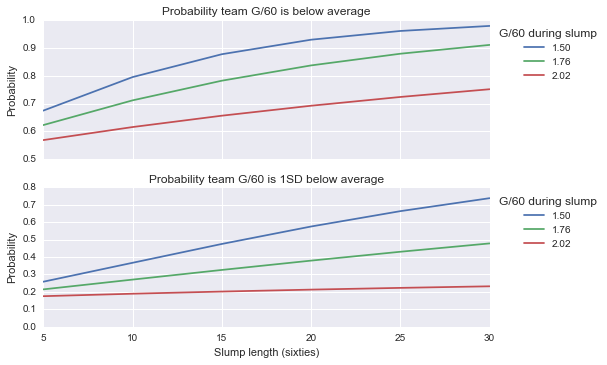

In [10]:
#x should be length of slump in sixties
#y should be probability you're below the mean/below 1SD
#color by goal scoring threshold
#different figure for Z < 0 and for Z < -1
fig, axes = plt.subplots(2, 1, sharex=True)

ax = axes[0]
g60vals = probabilities['G/60 during slump'].value_counts().index.sort_values()
for val in g60vals:
    temp = probabilities[probabilities['G/60 during slump'] == val]
    ax.plot(temp['Slump length'], temp['Probability (Z < 0)'], label='{0:.2f}'.format(val))
    ax.set_ylabel('Probability')
    #ax.set_xlabel('Slump length (sixties)')
    ax.set_title('Probability team G/60 is below average')
    ax.set_ylim(bottom=0.5)
ax.legend(loc=2, bbox_to_anchor=(1, 1), title='G/60 during slump')

ax = axes[1]
for val in g60vals:
    temp = probabilities[probabilities['G/60 during slump'] == val]
    ax.plot(temp['Slump length'], temp['Probability (Z < -1)'], label='{0:.2f}'.format(val))
    ax.set_ylabel('Probability')
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Slump length (sixties)')
    ax.set_title('Probability team G/60 is 1SD below average')
ax.legend(loc=2, bbox_to_anchor=(1, 1), title='G/60 during slump')

The way to use these graphs is to:
<ul>
<li>Find the team's slump length (in sixties of 5-on-5 play; this is approximately 75% of games played)
<li>Find the appropriate reference line, or guesstimate where that line is
<li>Read off the appropriate probability from the graph
</ul>

### Good offenses
<p>Of course, if your prior belief about a given slumping team is that its offense is above-average, any given slump is more worrisome than it would be for a team with an average-ish offense.
<p>To simply tackle this, all we need to do is construct another prior. Let's first take a look at some of the top offenses from the time period for which we have data handy:

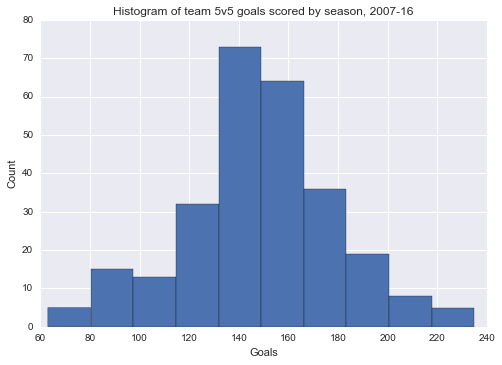

In [11]:
hist(df[(df.HR == 'Total') & (df.Season < 2016)]['G'])
xlabel('Goals')
ylabel('Count')
title('Histogram of team 5v5 goals scored by season, 2007-16')

Maybe what we could do is slice off the top five teams in goals per 60 in each season, and construct the prior based on that season, the previous season, and the following season. (Limiting ourselves to simply that season in which the team's offense scored a lot would basically just give us the right tail of this graph, and I think a reasonable prior belief here would look more like a normal distribution.)

In [12]:
### Filter top 5 by season
ranked = df.groupby(['Season', 'HR']).rank(method='first', ascending=False)
ranked.rename(columns={col: col+'Rank' for col in ranked.columns}, inplace=True)
ranked.reset_index(inplace=True)
df_r = pd.concat([df, ranked], axis=1)
df_r = df_r[(df_r.HR == 'Total') & (df_r.G60Rank <= 5)]

### Generate dataframe of acceptable team-seasons
team = [x for x in df_r.Team]*3
season = [x for x in df_r.Season] + [x-1 for x in df_r.Season] + [x+1 for x in df_r.Season]
tomerge = pd.DataFrame.from_dict({'Team': team, 'Season': season})

### Inner join with original df to filter 
top_offenses = df[df.HR == 'Total'].merge(tomerge, how='inner', on=['Team', 'Season'])

top_offenses.head()

,Team,Season,HR,G,SOG,TOI,TOI2,G60,SOG60,ShP
0,BUF,2007,Total,158,1750,214445,59.568056,2.652428,29.378162,0.090286
1,CHI,2007,Total,143,1626,206472,57.353333,2.493316,28.350575,0.087946
2,CGY,2007,Total,154,1779,231976,64.437778,2.389902,27.608028,0.086565
3,PIT,2007,Total,175,1987,264921,73.589167,2.378067,27.001257,0.088072
4,OTT,2007,Total,165,1872,224893,62.470278,2.641256,29.966251,0.088141


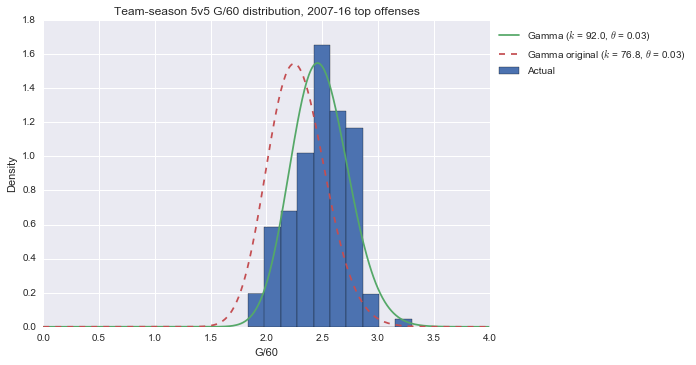

In [13]:
### Plot the prior and fit a gamma
hist(top_offenses.G60, normed=True, label='Actual', zorder=2)
#hist(g60df.G60, normed=True, label='Actual original', alpha=0.2)
xlabel('G/60')
ylabel('Density')
title('Team-season 5v5 G/60 distribution, 2007-16 top offenses')

k_g60_top, loc_g60_top, theta_g60_top = gamma.fit(top_offenses.G60, floc=0)
plot(xs_g60, gamma.pdf(xs_g60, k_g60_top, loc_g60_top, theta_g60_top), zorder=2,
     label=r"Gamma ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(k_g60_top, theta_g60_top))

### Overlay original
plot(xs_g60, gamma.pdf(xs_g60, k_g60, loc_g60, theta_g60), ls='--', 
     label=r"Gamma original ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(k_g60, theta_g60))

legend(loc=2, bbox_to_anchor=(1, 1))

The fit could stand to be better, but it's not terrible.
<p>Now, let's repeat the above exercise. First, the 2x3 matrix of posteriors (noting the x limits here are slightly larger than above):

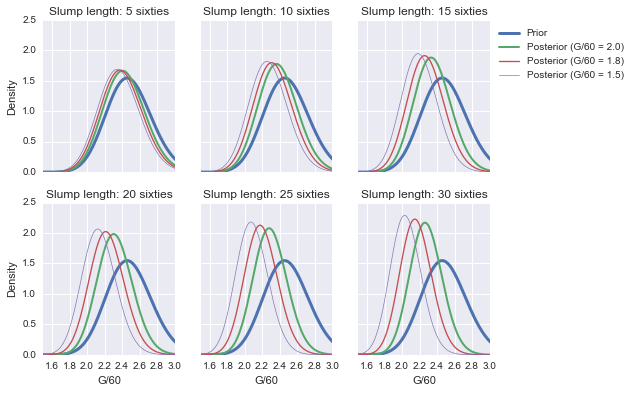

In [14]:
### Goals/60
fig, axes = subplots(2, 3, figsize=[8, 6], sharex=True, sharey=True)

below_avg_probs_top = {'G/60 during slump': [], 'Slump length': [], 'Probability (Z < 0)': [], 'Probability (Z < -1)': []}

for i in range(len(toi_thresholds)):
    row = i//3
    col = i % 3
    
    ax = axes[row, col]
    ax.plot(xs_g60, gamma.pdf(xs_g60, k_g60_top, loc_g60_top, theta_g60_top), lw=3, label="Prior")
    
    for j in range(len(g60_thresholds)):
        g60_thresh = g60_thresholds[j]
        updated_k = k_g60_top + g60_thresh * toi_thresholds[i]
        updated_theta = theta_g60_top/(theta_g60_top * toi_thresholds[i] + 1)
        posterior = gamma.pdf(xs_g60, updated_k, loc_g60, updated_theta)
        ax.plot(xs_g60, posterior, lw = 2 - j*(2/len(g60_thresholds)), 
                label="Posterior (G/60 = {0:.1f})".format(g60_thresh))

        ax.set_xlim(1.5, 3)
        
        if row == 1:
            ax.set_xlabel('G/60')
        if col == 0:
            ax.set_ylabel('Density')
        if row == 0 and col == 2:
            ax.legend(loc=2, bbox_to_anchor=(1, 1))
        ax.set_title('Slump length: {0:d} sixties'.format(toi_thresholds[i]))
        
        below_avg_probs_top['G/60 during slump'].append(g60_thresh)
        below_avg_probs_top['Slump length'].append(toi_thresholds[i])
        below_avg_probs_top['Probability (Z < 0)'].append(gamma.cdf(g60_mean, updated_k, loc_g60, updated_theta))
        below_avg_probs_top['Probability (Z < -1)'].append(gamma.cdf(g60_mean - g60_sd, updated_k, loc_g60, updated_theta))

It takes a little less time to start seeing some separation.

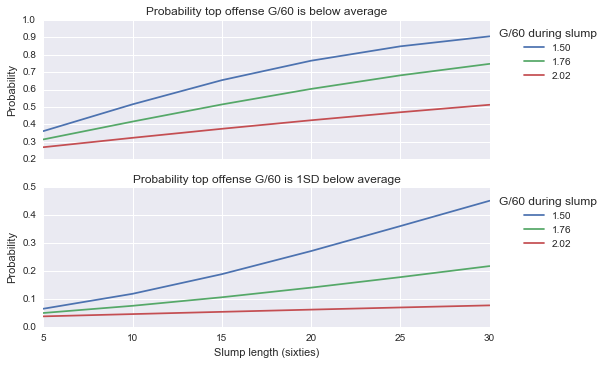

In [15]:
probabilities_top = pd.DataFrame.from_dict(below_avg_probs_top)

fig, axes = plt.subplots(2, 1, sharex=True)

ax = axes[0]
g60vals = probabilities_top['G/60 during slump'].value_counts().index.sort_values()
for val in g60vals:
    temp = probabilities_top[probabilities_top['G/60 during slump'] == val]
    ax.plot(temp['Slump length'], temp['Probability (Z < 0)'], label='{0:.2f}'.format(val))
    ax.set_ylabel('Probability')
    #ax.set_xlabel('Slump length (sixties)')
    ax.set_title('Probability top offense G/60 is below average')
    #ax.set_ylim(bottom=0.5)
ax.legend(loc=2, bbox_to_anchor=(1, 1), title='G/60 during slump')

ax = axes[1]
for val in g60vals:
    temp = probabilities_top[probabilities_top['G/60 during slump'] == val]
    ax.plot(temp['Slump length'], temp['Probability (Z < -1)'], label='{0:.2f}'.format(val))
    ax.set_ylabel('Probability')
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Slump length (sixties)')
    ax.set_title('Probability top offense G/60 is 1SD below average')
ax.legend(loc=2, bbox_to_anchor=(1, 1), title='G/60 during slump')